In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import sqlite3
import numpy as np
import networkx as nx

In [16]:
dir = os.getcwd()
genres_db_path = "dataset/genres.db"
metadata_db_path = "dataset/metadata.db"
tags_db_path = "dataset/tags.db"


In [17]:
def load_data():
    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    return genres_df, tags_df, metadata_df
genres_df, tags_df, metadata_df = load_data()

# Análisis exploratorio de los datos

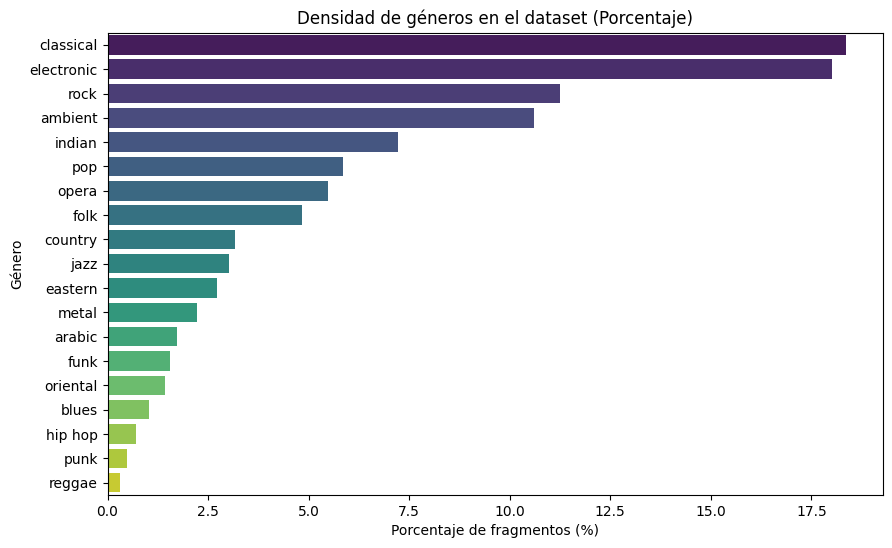

In [18]:
def visualize_density_genres(genres_df):
    """Visualiza la distribución relativa de géneros en el dataset."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])

    # Asegurarse de que todos los valores sean numéricos
    genres_df = genres_df.apply(pd.to_numeric, errors='coerce')

    genres_density = genres_df.sum(axis=0)

    total_fragments = genres_density.sum()
    genres_density = (genres_density / total_fragments) * 100

    genres_density = genres_density.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=genres_density.values,
        y=genres_density.index,
        hue=genres_density.index,
        palette="viridis",
        legend=False
    )
    plt.title("Densidad de géneros en el dataset (Porcentaje)")
    plt.xlabel("Porcentaje de fragmentos (%)")
    plt.ylabel("Género")
    plt.show()
visualize_density_genres(genres_df)

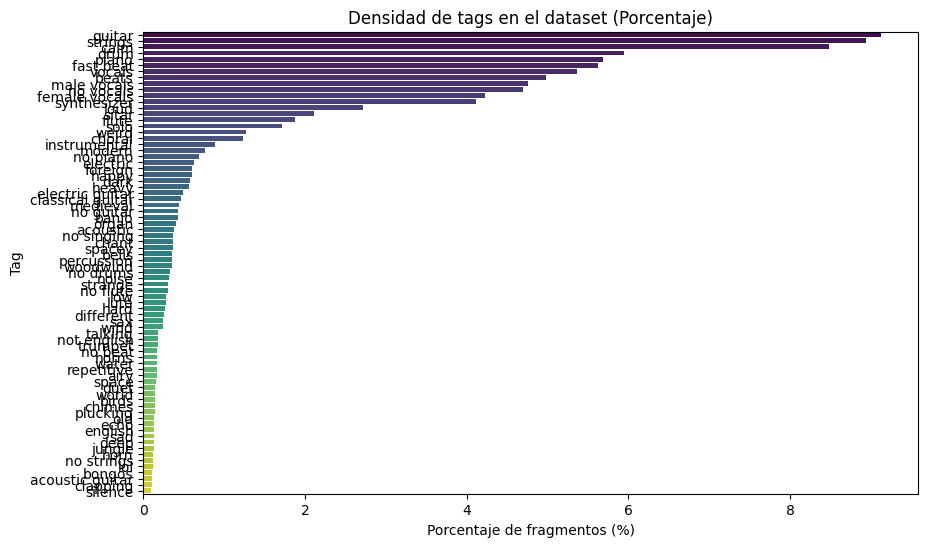

In [19]:
def visualize_density_tags(tags_df):
    """Visualiza la distribución relativa de tags en el dataset."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])
    tags_density = tags_df.sum(axis=0)

    total_fragments = tags_density.sum()
    tags_density = (tags_density / total_fragments) * 100
    tags_density = tags_density.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=tags_density.values, y=tags_density.index, hue=tags_density.index, palette="viridis", legend=False)
    plt.title("Densidad de tags en el dataset (Porcentaje)")
    plt.xlabel("Porcentaje de fragmentos (%)")
    plt.ylabel("Tag")
    plt.show()
visualize_density_tags(tags_df)

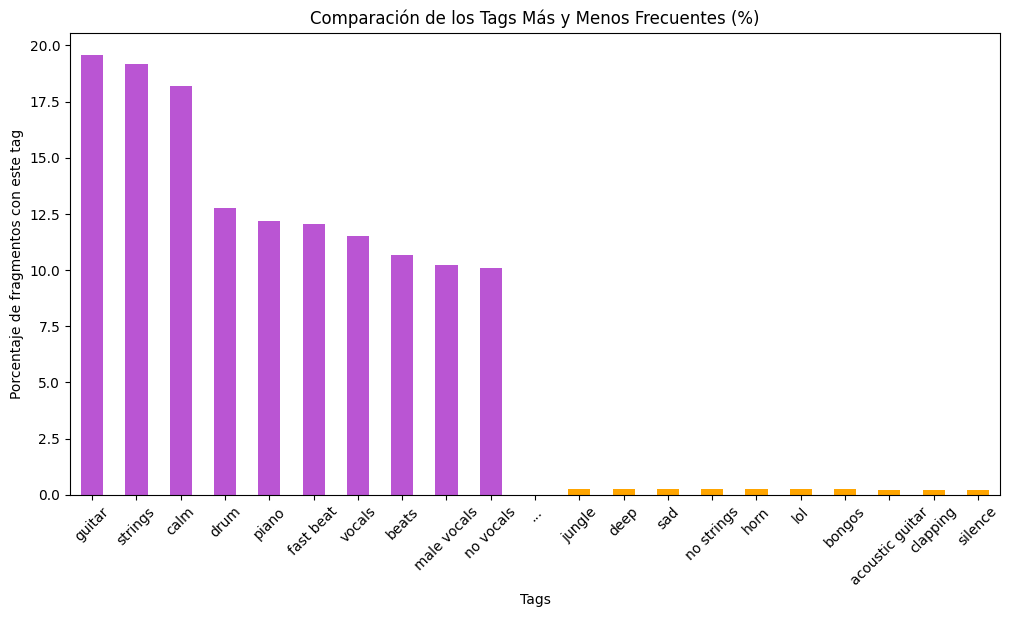

In [20]:
def visualize_stacked_bar(tags_df, top_n=10):
    """Muestra un gráfico de barras con los N tags más frecuentes a la izquierda,
    un separador en el centro y los N menos frecuentes a la derecha en orden descendente."""

    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    top_distribution = tags_df[top_tags].sum() / tags_df.shape[0] * 100

    separator = pd.Series([np.nan], index=["..."])

    bottom_tags = tags_df.sum().sort_values(ascending=True).head(top_n).index[::-1]
    bottom_distribution = tags_df[bottom_tags].sum() / tags_df.shape[0] * 100

    full_distribution = pd.concat([top_distribution, separator, bottom_distribution])

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ["mediumorchid"] * top_n + ["gray"] + ["orange"] * top_n

    full_distribution.plot(kind="bar", color=colors, ax=ax)

    plt.title("Comparación de los Tags Más y Menos Frecuentes (%)")
    plt.xlabel("Tags")
    plt.ylabel("Porcentaje de fragmentos con este tag")
    plt.xticks(rotation=45)
    plt.show()
visualize_stacked_bar(tags_df)

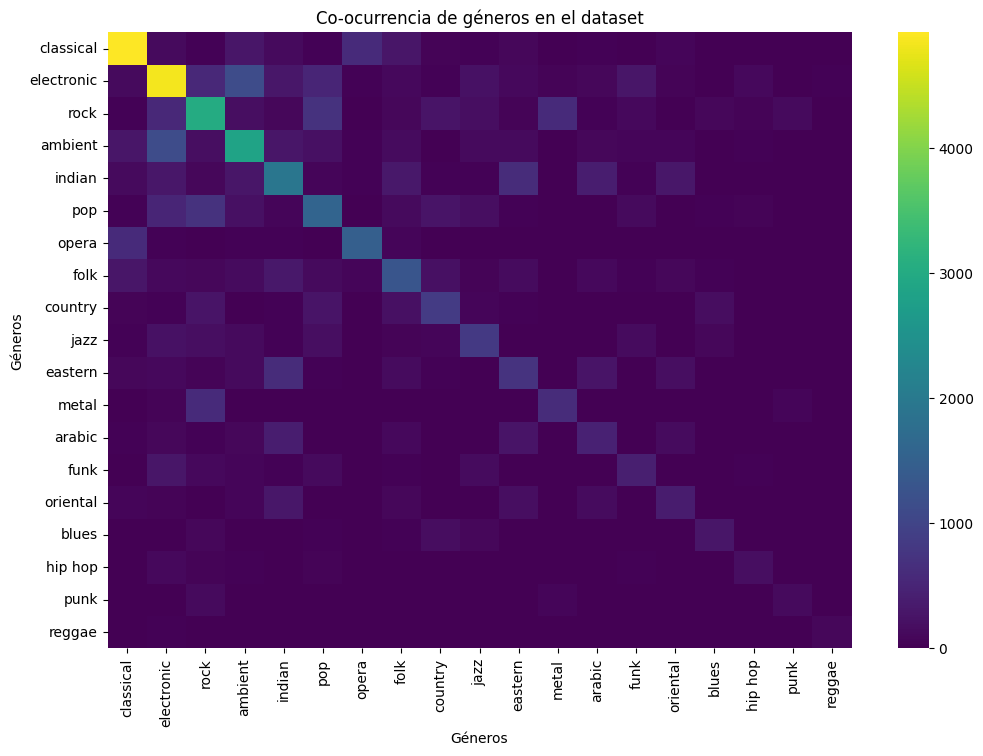

In [24]:
def visualize_genre_co_occurrence(genres_df, top_n=30):
    """Muestra una matriz de co-ocurrencia entre los géneros más frecuentes."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])

    top_genres = genres_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = genres_df[top_genres]
    correlation_matrix = filtered_df.T.dot(filtered_df)

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap="viridis", annot=False)
    plt.title("Co-ocurrencia de géneros en el dataset")
    plt.xlabel("Géneros")
    plt.ylabel("Géneros")
    plt.show()
visualize_genre_co_occurrence(genres_df, top_n=30)

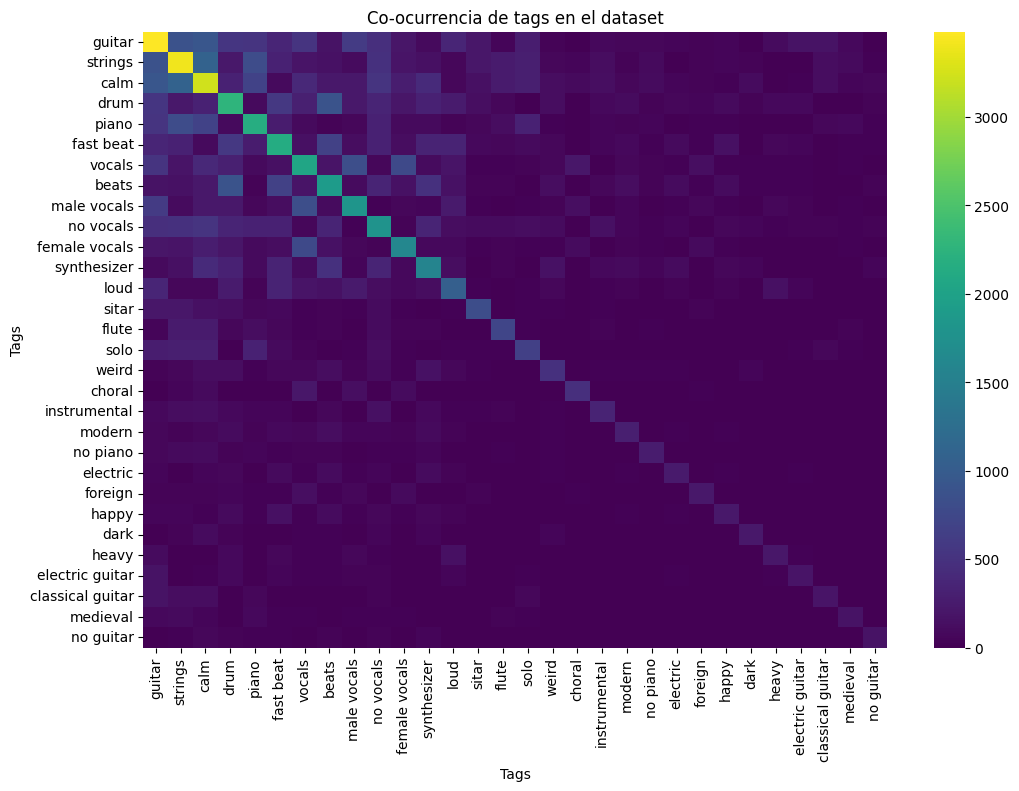

In [21]:
def visualize_tag_co_occurrence(tags_df, top_n=30):
    """Muestra una matriz de co-ocurrencia entre los tags más frecuentes."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = tags_df[top_tags]
    correlation_matrix = filtered_df.T.dot(filtered_df)

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap="viridis", annot=False)
    plt.title("Co-ocurrencia de tags en el dataset")
    plt.xlabel("Tags")
    plt.ylabel("Tags")
    plt.show()
visualize_tag_co_occurrence(tags_df)

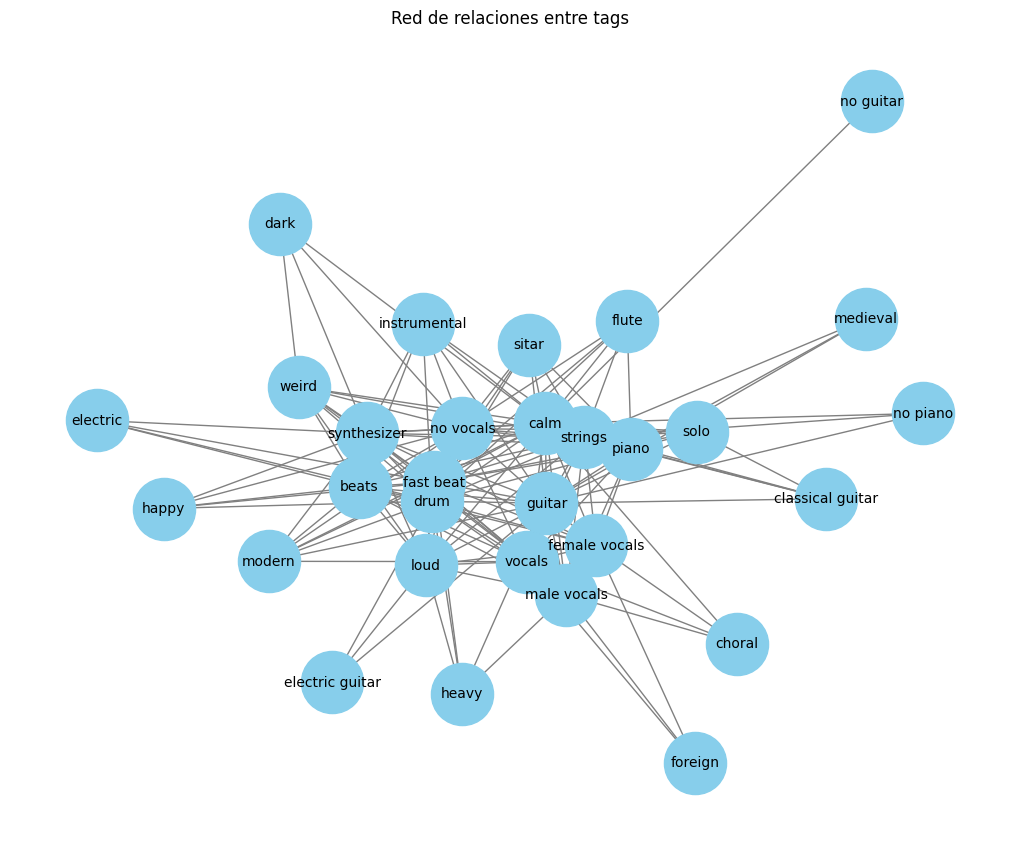

In [22]:
def visualize_tag_network(tags_df, top_n=30):
    """Genera una red de relaciones entre los tags más comunes."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])
    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = tags_df[top_tags]

    G = nx.Graph()
    WEIGHT_THRESHOLD = 50

    for tag1 in top_tags:
        for tag2 in top_tags:
            if tag1 != tag2:
                weight = (filtered_df[tag1] & filtered_df[tag2]).sum()
                if weight > WEIGHT_THRESHOLD:
                    G.add_edge(tag1, tag2, weight=weight)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    edges = G.edges(data=True)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2000, font_size=10)
    plt.title("Red de relaciones entre tags")
    plt.show()
visualize_tag_network(tags_df, top_n=30)

# Análisis estadístico

Tags activos por columna:
classical     4920
electronic    4826
rock          3013
ambient       2845
indian        1938
pop           1572
opera         1471
folk          1299
country        849
jazz           812
dtype: int64
acoustic          NaN
acoustic guitar   NaN
airy              NaN
ambient           NaN
arabic            NaN
                   ..
water             NaN
weird             NaN
wind              NaN
woodwind          NaN
world             NaN
Length: 95, dtype: float64


c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


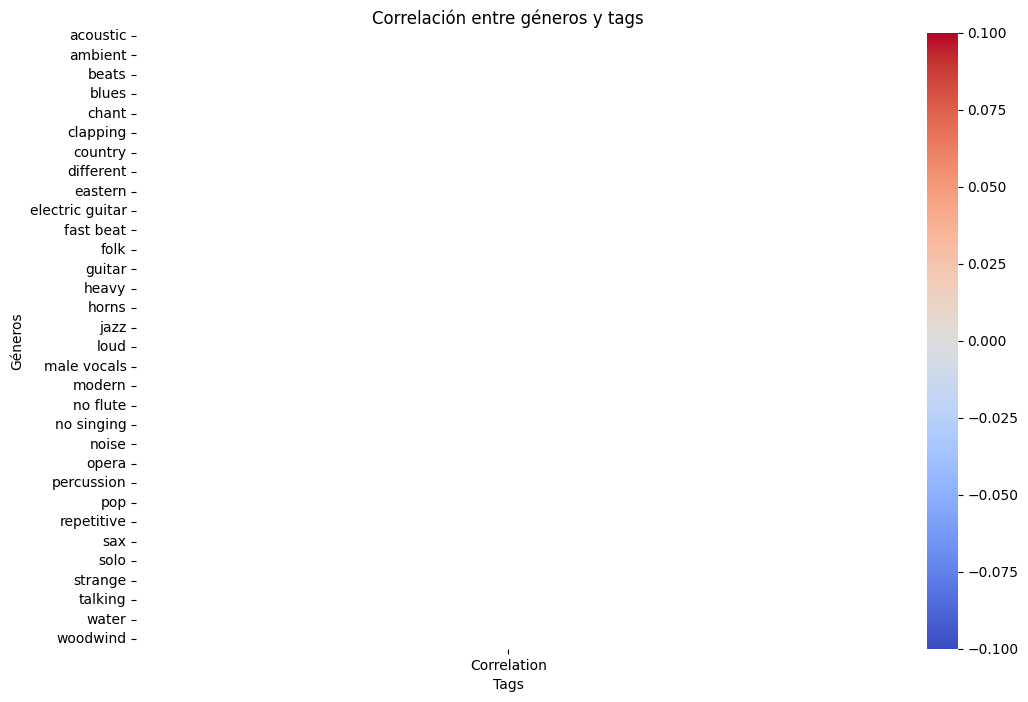